# CS336 Assignments

| # | Topic                         | Description                                 |
|---|-------------------------------|---------------------------------------------|
| 1 | Basics                        | Train an LLM from scratch                   |
| 2 | Systems                       | Make it run fast!                           |
| 3 | Scaling                       | Make it performant at a FLOP budget         |
| 4 | Data                          | Prepare the right datasets                  |
| 5 | Alignment & Reasoning RL      | Align it to real-world use cases            |

# Assignment #1
- Implement all of the components (tokenizer, model, loss function, optimizer) necessary to train a standard Transformer language model
- Train a minimal language model

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import lovely_tensors as lt
lt.monkey_patch()

import tiktoken

from datasets import load_dataset

## cross entropy loss

In [2]:
def crossentropyloss(actuals, preds):
    probs = preds.squeeze().sigmoid()
    eps = 1e-8
    loss = - actuals * (probs + eps).log() - (1 - actuals) * ((1 - probs) + eps).log()
    return loss.mean()


In [3]:
torch.manual_seed(42)
preds = torch.randn(1, 5)
actuals = torch.tensor([1, 1, 0, 0, 1])

crossentropyloss(actuals, preds)

tensor 0.841

In [4]:
bce = torch.nn.BCEWithLogitsLoss()
bce(preds.squeeze(), actuals.float())

tensor 0.841

In [5]:
ce = torch.nn.CrossEntropyLoss()
ce(preds.flatten(), actuals.float())

tensor 5.709

## AdamW optimizer (PyTorch implementation)

In [6]:
torch.manual_seed(42)

model = torch.nn.Linear(3, 1)
optimizer = torch.optim.AdamW(model.parameters())

x = torch.randn(10, 3)
y = torch.randn(10, 1)

In [7]:
n_steps = 10

for i in range(n_steps):

    optimizer.zero_grad()
    logits = model(x)
    loss = torch.nn.functional.mse_loss(logits.squeeze(), y.float())
    loss.backward()
    optimizer.step()
    print(f"step: {i:3d} | loss: {loss.item(): .4f}")

step:   0 | loss:  0.9286
step:   1 | loss:  0.9260
step:   2 | loss:  0.9234
step:   3 | loss:  0.9207
step:   4 | loss:  0.9181
step:   5 | loss:  0.9155
step:   6 | loss:  0.9129
step:   7 | loss:  0.9103
step:   8 | loss:  0.9077
step:   9 | loss:  0.9051


## AdamW optimizer (our custom implementation)
Now, let's implement the AdamW optimizer!

In [8]:
class AdamW_custom:
    def __init__(self, params, lr=3e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2):
        self.params = params
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.wd = weight_decay
        self.eps = eps
        self.step_count = 0

        # Initialize momentum and velocity for each parameter
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def zero_grad(self):
        pass

    def step(self):
        pass

In [9]:
torch.zeros_like(torch.tensor(5))

tensor i64 0

In [10]:
torch.zeros(5)

tensor[5] all_zeros [0., 0., 0., 0., 0.]

In [11]:
torch.manual_seed(42)

model = torch.nn.Linear(3, 1)
optimizer = AdamW_custom(model.parameters())

x = torch.randn(10, 3)
y = torch.randn(10, 1)

In [12]:
n_steps = 10

for i in range(n_steps):

    optimizer.zero_grad()
    logits = model(x)
    loss = torch.nn.functional.mse_loss(logits.squeeze(), y.float())
    loss.backward()
    optimizer.step()
    print(f"step: {i:3d} | loss: {loss.item(): .4f}")

step:   0 | loss:  0.9286
step:   1 | loss:  0.9286
step:   2 | loss:  0.9286
step:   3 | loss:  0.9286
step:   4 | loss:  0.9286
step:   5 | loss:  0.9286
step:   6 | loss:  0.9286
step:   7 | loss:  0.9286
step:   8 | loss:  0.9286
step:   9 | loss:  0.9286


Clearly, the network is not learning anything as our optimizer is not updating the weights. Let's go ahead and fill up the implementation.

In [13]:
class AdamW_custom:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.wd = weight_decay
        self.eps = eps
        self.step_count = 0

        # Initialize momentum and velocity for each parameter
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        self.step_count += 1

        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            grad = param.grad.data

            # Apply weight decay directly to parameters (AdamW style)
            param.data.mul_(1 - self.lr * self.wd)

            # Update biased first moment estimate
            # beta1 * i + (1-beta2) * grad
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta2) * grad

            # Update biased second raw moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad.pow(2)
            
            # Compute bias-corrected first moment estimate
            m_hat = self.m[i] / (1 - self.beta1 ** self.step_count)

            # Compute bias-corrected second raw moment estimate
            v_hat = self.v[i] / (1 - self.beta2 ** self.step_count)

            # Update parameters
            param.data.add_(m_hat * -self.lr/ (v_hat.sqrt() + self.eps))

        # print(sum([p for p in self.params]))



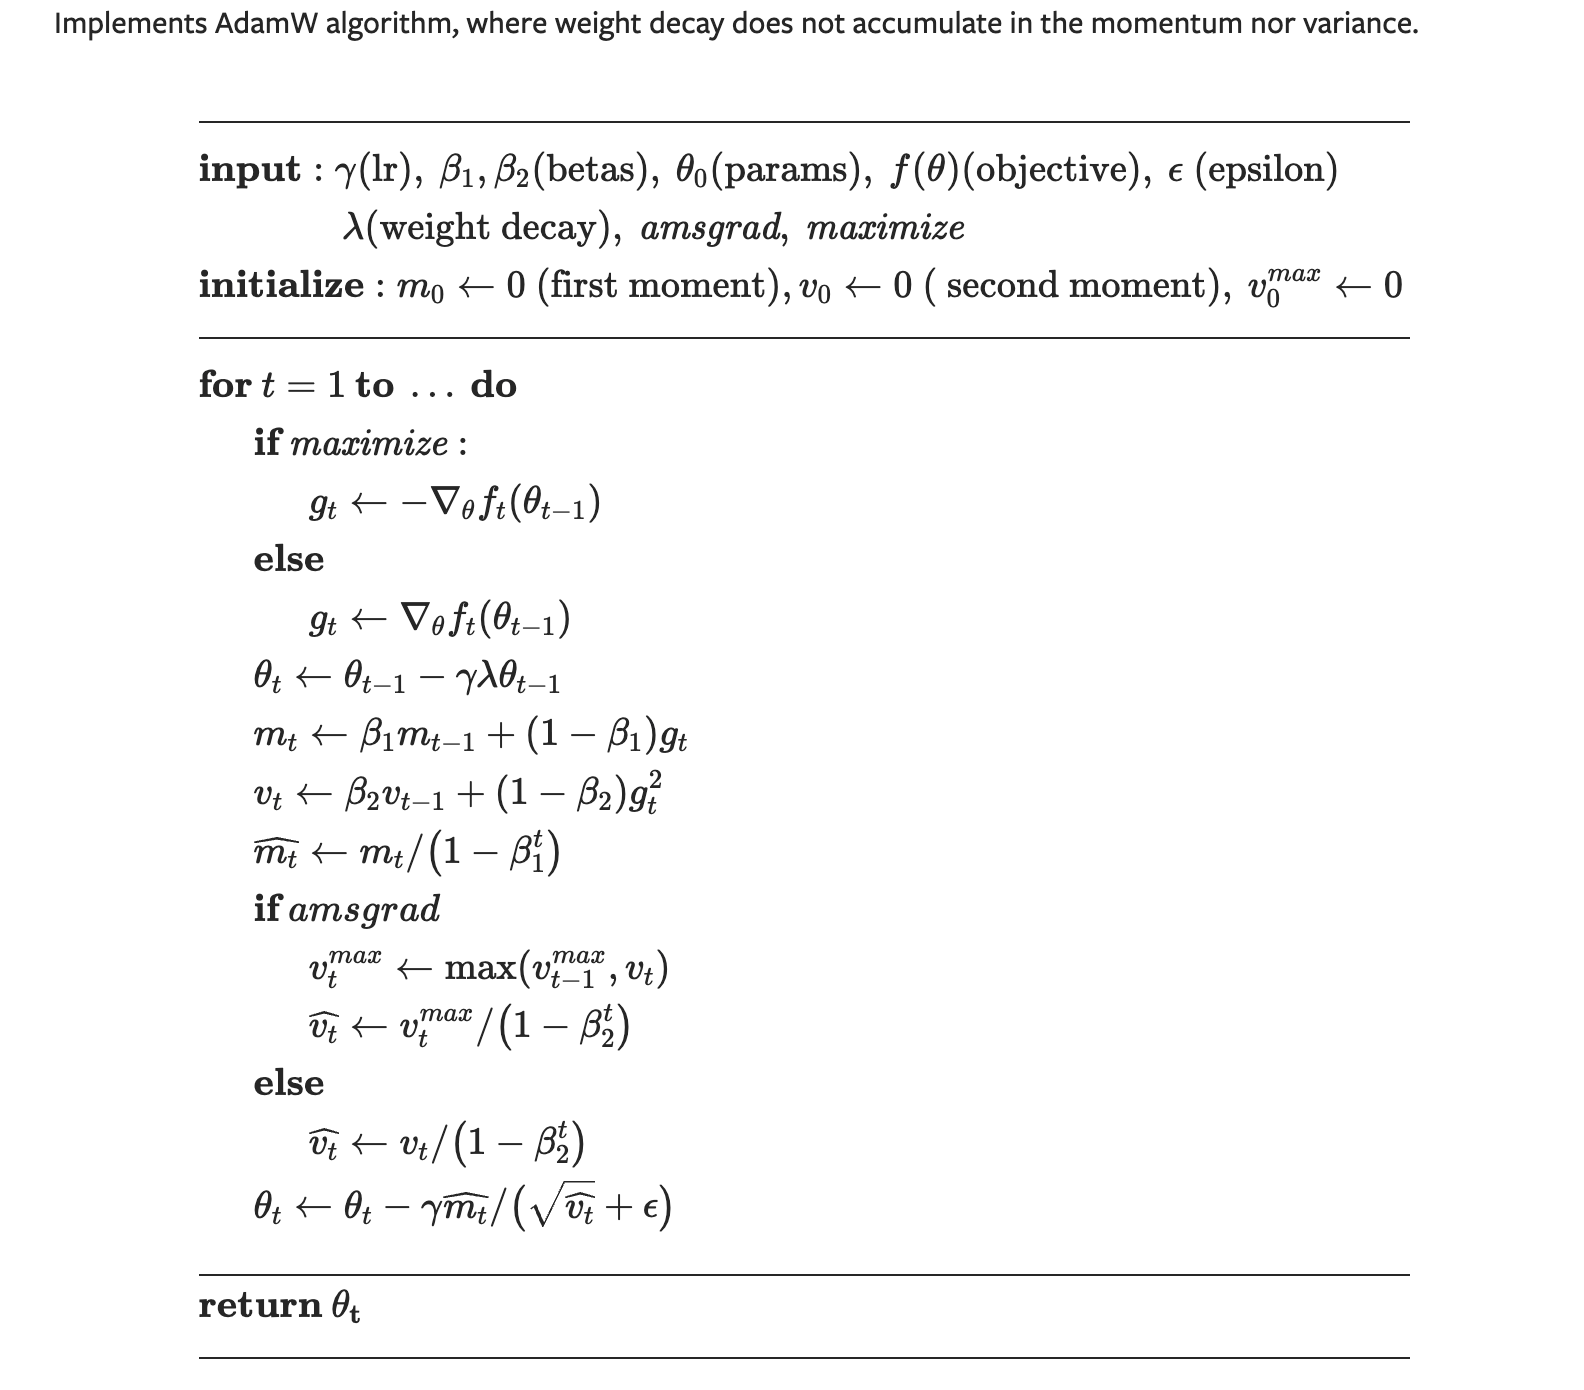

In [14]:
torch.manual_seed(42)

model = torch.nn.Linear(3, 1)
optimizer = AdamW_custom(model.parameters())
# optimizer = torch.optim.AdamW(model.parameters())

x = torch.randn(10, 3)
y = torch.randn(10, 1)

n_steps = 10

for i in range(n_steps):

    optimizer.zero_grad()
    logits = model(x)
    loss = torch.nn.functional.mse_loss(logits.squeeze(), y.float())
    loss.backward()
    optimizer.step()
    print(f"step: {i:3d} | loss: {loss.item(): .4f}")

step:   0 | loss:  0.9286
step:   1 | loss:  0.9286
step:   2 | loss:  0.9286
step:   3 | loss:  0.9285
step:   4 | loss:  0.9285
step:   5 | loss:  0.9285
step:   6 | loss:  0.9285
step:   7 | loss:  0.9284
step:   8 | loss:  0.9284
step:   9 | loss:  0.9284


Clearly, something is wrong in the AdamW_custom code. Hmm!

Ah, the error is in this line.

`self.m[i] = self.beta1 * self.m[i] + (1 - self.beta2) * grad` 

In [15]:
class AdamW_custom:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.wd = weight_decay
        self.eps = eps
        self.step_count = 0

        # Initialize momentum and velocity for each parameter
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        self.step_count += 1

        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            grad = param.grad.data

            # Apply weight decay directly to parameters (AdamW style)
            param.data.mul_(1 - self.lr * self.wd)

            # Update biased first moment estimate
            # beta1 * i + (1-beta1) * grad
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad

            # Update biased second raw moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad.pow(2)
            
            # Compute bias-corrected first moment estimate
            m_hat = self.m[i] / (1 - self.beta1 ** self.step_count)

            # Compute bias-corrected second raw moment estimate
            v_hat = self.v[i] / (1 - self.beta2 ** self.step_count)

            # Update parameters
            param.data.add_(m_hat * -self.lr/ (v_hat.sqrt() + self.eps))

        # print(sum([p for p in self.params]))



In [16]:
torch.manual_seed(42)

model = torch.nn.Linear(3, 1)
optimizer = AdamW_custom(model.parameters())
# optimizer = torch.optim.AdamW(model.parameters())

x = torch.randn(10, 3)
y = torch.randn(10, 1)

n_steps = 10

for i in range(n_steps):

    optimizer.zero_grad()
    logits = model(x)
    loss = torch.nn.functional.mse_loss(logits.squeeze(), y.float())
    loss.backward()
    optimizer.step()
    print(f"step: {i:3d} | loss: {loss.item(): .4f}")

step:   0 | loss:  0.9286
step:   1 | loss:  0.9260
step:   2 | loss:  0.9234
step:   3 | loss:  0.9207
step:   4 | loss:  0.9181
step:   5 | loss:  0.9155
step:   6 | loss:  0.9129
step:   7 | loss:  0.9103
step:   8 | loss:  0.9077
step:   9 | loss:  0.9051


In [20]:
class MyAdamW(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2):
        defaults = {
            'lr': lr,
            'eps': eps,
            'betas': betas,
            'weight_decay': weight_decay
        }
        super().__init__(params, defaults=defaults)
        # self.params = list(params)
        # self.lr = lr
        # self.beta1, self.beta2 = betas
        # self.wd = weight_decay
        # self.eps = eps
        # self.step_count = 0

        # Initialize momentum and velocity for each parameter
        # self.m = [torch.zeros_like(p) for p in self.params]
        # self.v = [torch.zeros_like(p) for p in self.params]

        # self.ckpt = {}
        # self.ckpt['param_groups'] = [{
        #     'lr': lr,
        #     'eps': eps,
        #     'betas': (self.beta1, self.beta2),
        #     'weight_decay': self.wd
        # }]

    def zero_grad(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.zero_()

    def step(self):
        # self.step_count += 1

        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['betas']
            eps = group['eps']
            wd = group['weight_decay']

            for i, param in enumerate(group['params']):
                if param.grad is None:
                    continue

                grad = param.grad.data

                # get state associated with param
                state = self.state[param]
                if len(state) == 0:
                    state['t'] = 0
                    state['m'] = torch.zeros_like(param.data)
                    state['v'] = torch.zeros_like(param.data)

                t = state['t'] + 1
                m = state['m']
                v = state['v']

                # Apply weight decay directly to parameters (AdamW style)
                param.data.mul_(1 - lr * wd)

                # Update biased first moment estimate
                # beta1 * i + (1-beta1) * grad
                # self.m = self.beta1 * self.m + (1 - self.beta1) * grad
                m.mul_(beta1).add_(grad, alpha = 1-beta1)

                # Update biased second raw moment estimate
                # self.v = self.beta2 * self.v + (1 - self.beta2) * grad.pow(2)
                v.mul_(beta2).addcmul(grad, grad, value = 1 - beta2)
                
                # Compute bias-corrected first moment estimate
                m_hat = m / (1 - beta1 ** t)
                bias_correction1 = 1 - beta1 ** t
                bias_correction2 = 1 - beta2 ** t

                # Update parameters
                denom = ((v.sqrt() / bias_correction2 ** 0.5)).add_(eps)
                step_size = lr / bias_correction1

                param.data.addcdiv_(m, denom, value=-step_size)

                # Compute bias-corrected second raw moment estimate
                # v_hat = v / (1 - beta2 ** t)

                # # Update parameters
                # param.data.add_(m_hat * -lr/ (v_hat.sqrt() + eps))

                state['t'] = t

torch.manual_seed(42)

model = torch.nn.Linear(3, 1)
optimizer = MyAdamW(model.parameters())
# optimizer = torch.optim.AdamW(model.parameters())

x = torch.randn(10, 3)
y = torch.randn(10, 1)

n_steps = 10

for i in range(n_steps):

    optimizer.zero_grad()
    logits = model(x)
    loss = torch.nn.functional.mse_loss(logits.squeeze(), y.float())
    loss.backward()
    optimizer.step()
    print(f"step: {i:3d} | loss: {loss.item(): .4f}")

step:   0 | loss:  0.9286
step:   1 | loss:  26239750144.0000
step:   2 | loss:  602600066753146912768.0000
step:   3 | loss:  8473069114093498952569896042496.0000
step:   4 | loss:  inf
step:   5 | loss:  inf
step:   6 | loss:  inf
step:   7 | loss:  inf
step:   8 | loss:  nan
step:   9 | loss:  nan


Loss is exploding. Gotta investigate why! :(

The losses are fixed now. They are matching PyTorch's values!

## Adam optimizer (PyTorch implementation)

In [29]:
torch.manual_seed(42)

model = torch.nn.Linear(3, 1)
optimizer = torch.optim.Adam(model.parameters())

x = torch.randn(10, 3)
y = torch.randn(10, 1)

n_steps = 10

for i in range(n_steps):

    optimizer.zero_grad()
    logits = model(x)
    loss = torch.nn.functional.mse_loss(logits.squeeze(), y.float())
    loss.backward()
    optimizer.step()
    print(f"step: {i:3d} | loss: {loss.item(): .4f}")

step:   0 | loss:  0.9286
step:   1 | loss:  0.9260
step:   2 | loss:  0.9234
step:   3 | loss:  0.9207
step:   4 | loss:  0.9181
step:   5 | loss:  0.9155
step:   6 | loss:  0.9129
step:   7 | loss:  0.9103
step:   8 | loss:  0.9077
step:   9 | loss:  0.9052


## Adam optimizer (Our custom implementation)

In [169]:
class Adam_custom:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), weight_decay=False, eps=1e-8):
        super().__init__()

        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.wd = weight_decay
        self.eps = eps

        self.step_count = 0
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        self.step_count += 1

        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            grad = p.grad.data

            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad

            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad.pow(2)

            m_hat = self.m[i] / (1 - self.beta1 ** self.step_count)

            v_hat = self.v[i] / (1 - self.beta2 ** self.step_count)

            p.data.add_(m_hat * -self.lr / (v_hat.sqrt() + self.eps))


In [170]:
torch.manual_seed(42)

model = torch.nn.Linear(3, 1)
optimizer = Adam_custom(model.parameters())

x = torch.randn(10, 3)
y = torch.randn(10, 1)

n_steps = 10

for i in range(n_steps):

    optimizer.zero_grad()
    logits = model(x)
    loss = torch.nn.functional.mse_loss(logits.squeeze(), y.float())
    loss.backward()
    optimizer.step()
    print(f"step: {i:3d} | loss: {loss.item(): .4f}")

step:   0 | loss:  0.9286
step:   1 | loss:  0.9260
step:   2 | loss:  0.9234
step:   3 | loss:  0.9207
step:   4 | loss:  0.9181
step:   5 | loss:  0.9155
step:   6 | loss:  0.9129
step:   7 | loss:  0.9103
step:   8 | loss:  0.9077
step:   9 | loss:  0.9052


The outputs match between PyTorch's adam optimizer and our Adam optimizer!

## RMSProp optimizer (PyTorch implementation)

In [177]:
torch.manual_seed(42)

model = torch.nn.Linear(3, 1)
optimizer = torch.optim.RMSprop(model.parameters())

x = torch.randn(10, 3)
y = torch.randn(10, 1)

n_steps = 10

for i in range(n_steps):

    optimizer.zero_grad()
    logits = model(x)
    loss = torch.nn.functional.mse_loss(logits.squeeze(), y.float())
    loss.backward()
    optimizer.step()
    print(f"step: {i:3d} | loss: {loss.item(): .4f}")

step:   0 | loss:  0.9286
step:   1 | loss:  0.7056
step:   2 | loss:  0.6156
step:   3 | loss:  0.5686
step:   4 | loss:  0.5414
step:   5 | loss:  0.5247
step:   6 | loss:  0.5140
step:   7 | loss:  0.5069
step:   8 | loss:  0.5019
step:   9 | loss:  0.4984


## RMSProp optimizer (Our custom implementation)

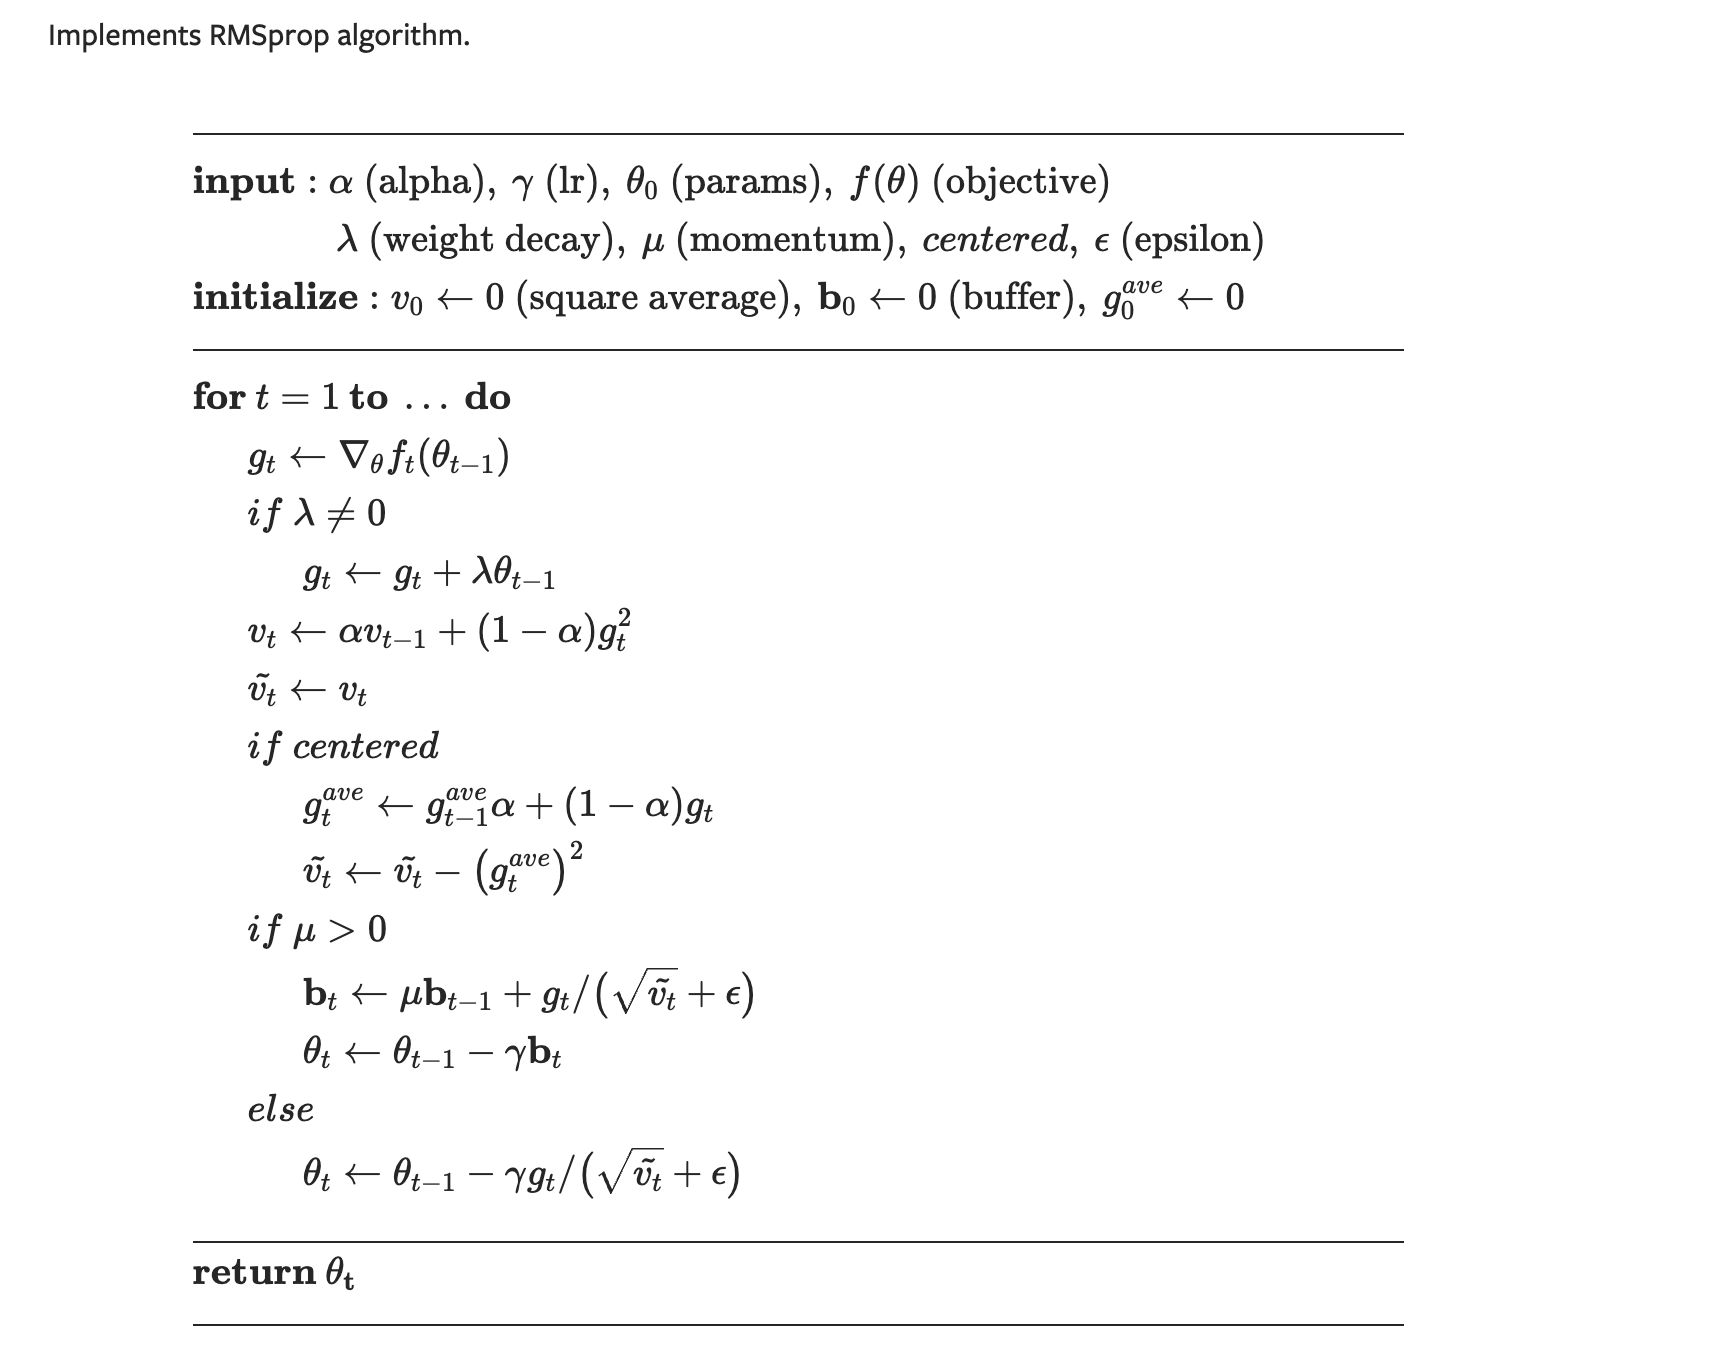

In [186]:
class RMSProp_Custom:
    def __init__(self, params, lr=1e-2, alpha=0.99, weight_decay=0, mom=0, eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.alpha = alpha
        self.wd = weight_decay
        self.mom = mom
        self.eps = eps
        self.step_count = 0

        # velocity vector
        self.v = [torch.zeros_like(x) for x in self.params]

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        self.step_count += 1

        for i, p in enumerate(self.params):
            grad = p.grad
            self.v[i] = self.alpha * self.v[i] + (1 - self.alpha) * grad.pow(2)

            v_hat = self.v[i]

            p.data.add_(-self.lr * grad / v_hat.sqrt() + self.eps)            

In [190]:
torch.manual_seed(42)

model = torch.nn.Linear(3, 1)
optimizer = RMSProp_Custom(model.parameters())

x = torch.randn(10, 3)  
y = torch.randn(10, 1)

n_steps = 10

for i in range(n_steps):

    optimizer.zero_grad()
    logits = model(x)
    loss = torch.nn.functional.mse_loss(logits.squeeze(), y.float())
    loss.backward()
    optimizer.step()
    print(f"step: {i:3d} | loss: {loss.item(): .4f}")


step:   0 | loss:  0.9286
step:   1 | loss:  0.7056
step:   2 | loss:  0.6156
step:   3 | loss:  0.5686
step:   4 | loss:  0.5414
step:   5 | loss:  0.5247
step:   6 | loss:  0.5140
step:   7 | loss:  0.5069
step:   8 | loss:  0.5019
step:   9 | loss:  0.4984


The outputs match between PyTorch's RMSProp optimizer and our RMSProp optimizer!